# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd
from xclim.sdba import nbutils

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [70]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/pr-qdc-adjustment-factors-multiplicative-ssr_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
adjustment_file_31day = '/g/data/wp00/users/dbi599/test_space/pr-qdc-adjustment-factors-multiplicative-31day-ssr_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc'
qq_file = "/g/data/wp00/users/dbi599/test_space/pr-qdc-multiplicative-ssr_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
example_lat = -19.26
example_lon = 146.8
example_month = 5
hist_units = "kg m-2 s-1"
ref_units = "kg m-2 s-1"
target_units = "mm d-1"
output_units = "mm d-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2035-01-01 2064-12-31"
target_time_bounds = "1990-01-01 2019-12-31"


In [5]:
# Required parameters
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

plot_config = {}
if hist_var in ['tasmax', 'tasmin']:
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = None
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = None
elif hist_var in ['pr']:
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

## Read data

In [7]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)
ds_hist[hist_var]

<xarray.DataArray 'pr' (time: 7305, lat: 145, lon: 192)>
dask.array<rechunk-merge, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:41:46Z altered by CMOR: replaced missing va...

In [8]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)
ds_ref[ref_var]

<xarray.DataArray 'pr' (time: 10958, lat: 145, lon: 192)>
dask.array<mul, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T10:39:53Z altered by CMOR: replaced missing va...

In [9]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [10]:
ds_target[target_var]

<xarray.DataArray 'precip' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-precip, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm d-1

In [11]:
ds_adjust = xr.open_dataset(adjustment_file)

In [73]:
ds_adjust

<xarray.Dataset>
Dimensions:    (lon: 192, lat: 145, month: 12, quantiles: 100)
Coordinates:
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (quantiles, month, lat, lon) float64 ...
    hist_q     (quantiles, month, lat, lon) float64 ...
    ref_q      (quantiles, month, lat, lon) float64 ...
Attributes:
    _xclim_adjustment:        {"py/object": "xclim.sdba.adjustment.EmpiricalQ...
    adj_params:               EmpiricalQuantileMapping(group=Grouper(add_dims...
    history:                  Fri Dec 02 12:52:23 2022: /g/data/xv83/dbi599/m...
    historical_period_start:  1995-01-01
    historical_period_end:    2014-12-31
    reference_period_start:   2035-01-01
    reference_period_end:     2064-12-31
    xclim_version:            0.36.0

In [71]:
ds_adjust_31day = xr.open_dataset(adjustment_file_31day)

In [72]:
ds_adjust_31day

<xarray.Dataset>
Dimensions:    (lat: 145, lon: 192, dayofyear: 366, quantiles: 100)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (quantiles, dayofyear, lat, lon) float64 ...
    hist_q     (quantiles, dayofyear, lat, lon) float64 ...
Attributes:
    _xclim_adjustment:        {"py/object": "xclim.sdba.adjustment.EmpiricalQ...
    adj_params:               EmpiricalQuantileMapping(group=Grouper(add_dims...
    history:                  Tue Dec 06 15:50:30 2022: /g/data/xv83/dbi599/m...
    historical_period_start:  1995-01-01
    historical_period_end:    2014-12-31
    reference_period_start:   2035-01-01
    reference_period_end:     2064-12-31
    xclim_version:            0.36.0

In [13]:
target_q = utils.get_ref_q(ds_target[target_var], ds_adjust['quantiles'].data)

[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  4min 41.3s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 21.5s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 18.1s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 17.9s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 17.6s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 19.5s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 18.2s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 18.0s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 18.2s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 19.0s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 18.7s
[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[########################################] | 100% Completed |  1min 18.0s


In [14]:
target_q = target_q.compute()

In [12]:
ds_qq = xr.open_dataset(qq_file)

In [13]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

In [14]:
print(lat_min_qq, lat_max_qq, lon_min_qq, lon_max_qq)

-44.5 -10.0 112.0 156.25


## Quantile mapping

In [75]:
def quantile_month_plot(da, ax, cmap_type, levels=None, extend='both', point=None, title=None, group_dim='month'):
    """Create two dimensional month/quantile plot"""
    
    assert cmap_type in ['regular', 'diverging']
    
    if 'lat' in da.dims:
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
    
    quantiles.transpose(group_dim, 'quantiles').plot(ax=ax, cmap=cmap, extend=extend, **kwargs)
    
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    ax.set_yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

In [16]:
def quantile_spatial_plot(
    da, month, cmap_type, lat_bounds=None, lon_bounds=None, levels=None,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min, lat_max = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min, lat_max))
    if lon_bounds:
        lon_min, lon_max = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min, lon_max))
        
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
        
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        **kwargs,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

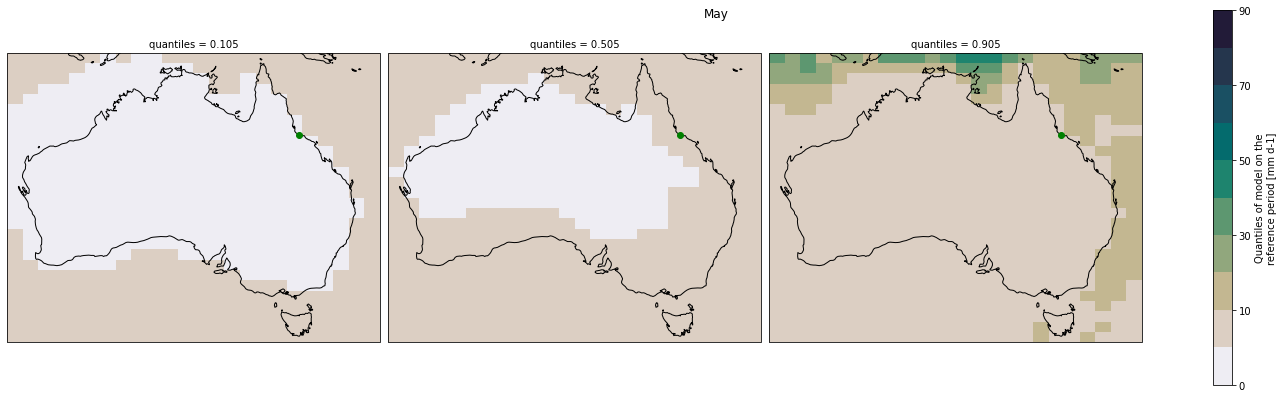

In [20]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        'regular',
        levels=plot_config['general_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

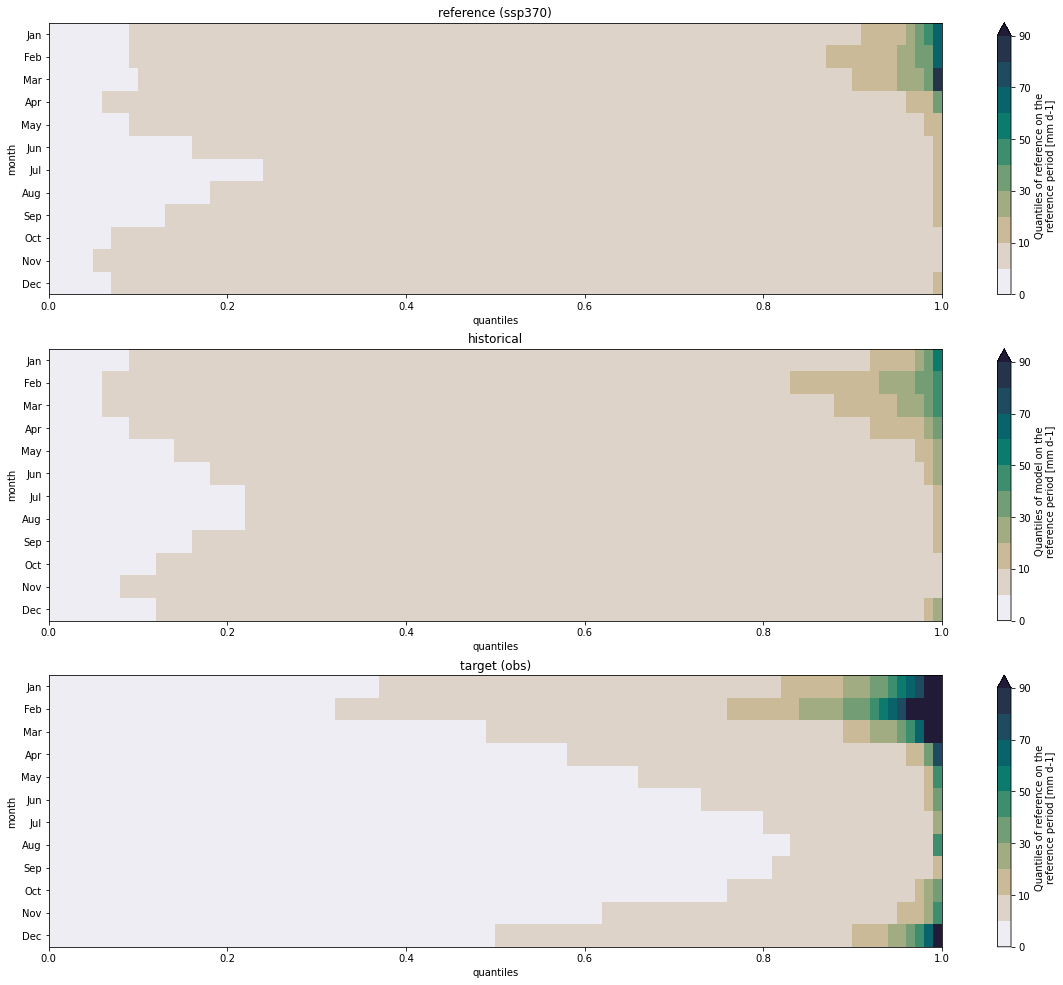

In [21]:
fig = plt.figure(figsize=[20, 17])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quantile_month_plot(
    ds_adjust['ref_q'],
    ax1,
    'regular',
    levels=plot_config['general_levels'],
    title='reference (ssp370)',
    extend='max',
)

quantile_month_plot(
    ds_adjust['hist_q'],
    ax2,
    'regular',
    levels=plot_config['general_levels'],
    title='historical',
    extend='max',
)

quantile_month_plot(
    target_q,
    ax3,
    'regular',
    levels=plot_config['general_levels'],
    title='target (obs)',
    extend='max',
)

plt.show()

In [17]:
da_hist = ds_hist[hist_var].sel({'lat': example_lat, 'lon': example_lon}, method='nearest')
da_hist = da_hist[da_hist['time'].dt.month == example_month]
df_hist = pd.DataFrame(da_hist.values, columns=[hist_var])

[########################################] | 100% Completed |  8.9s


In [18]:
da_ref = ds_ref[ref_var].sel({'lat': example_lat, 'lon': example_lon}, method='nearest')
da_ref = da_ref[da_ref['time'].dt.month == example_month]
df_ref = pd.DataFrame(da_ref.values, columns=[hist_var])

[########################################] | 100% Completed | 16.3s


In [65]:
da_target = ds_target[target_var].sel({'lat': example_lat, 'lon': example_lon}, method='nearest')
da_target = da_target[da_target['time'].dt.month == example_month]

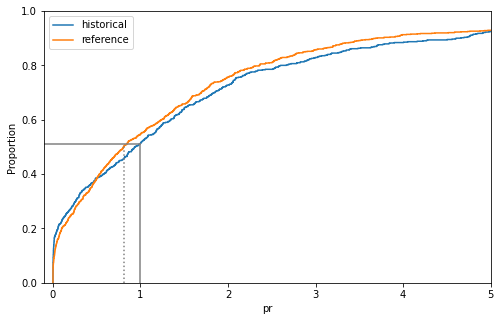

In [56]:
fig = plt.figure(figsize=[8, 5])
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

sns.ecdfplot(ax=ax1, data=df_hist, x=hist_var, color='tab:blue', label='historical')
sns.ecdfplot(ax=ax1, data=df_ref, x=hist_var, color='tab:orange', label='reference')
ax1.legend()
ax1.plot([1, 1], [0, 0.51], color='0.5')
ax1.plot([-0.1, 1], [0.51, 0.51], color='0.5')
ax1.plot([0.81, 0.81], [0, 0.51], color='0.5', linestyle=':')
ax1.set_xlim(-0.1, 5)
plt.show()

So for a 1mm day in the observational record, the empirical quantile mapping works as follows:
1. Find the probability that 1mm is exceeded in the historical data (0.51)
2. Find the precipitation total corresponding to that probability in the reference data (0.81mm)
3. The multiplicative adjustment factor is the ratio between 0.81 and 1.0mm

In other words, for a given daily precipitation total in the observational record the xclim software uses `hist_q` to look up the quantile corresponding to that precipitation total and then uses `af` to find the adjustment factor for the quantile.

In [68]:
da_hist.values.max()

[########################################] | 100% Completed |  4.4s


40.518036

In [69]:
np.sort(da_target.values)[::-1][0:7]

[########################################] | 100% Completed |  1min 19.6s


array([128.78125 ,  50.506836,  49.69336 ,  45.217773,  43.76367 ,
        42.73047 ,  37.71582 ], dtype=float32)

An issue here is that there are days at this grid point in the observations with rainfall totals beyond the maximum that occurs in the model. Those high rainfall totals can't be linked to a corresponding historical probability, so the adjustment factor at the last quantile is used. That adjustment factor is very large, so all the days in the obs that are beyond the model maximum get scaled up dramatically, resulting in a substantial change in the mean rainfall. 

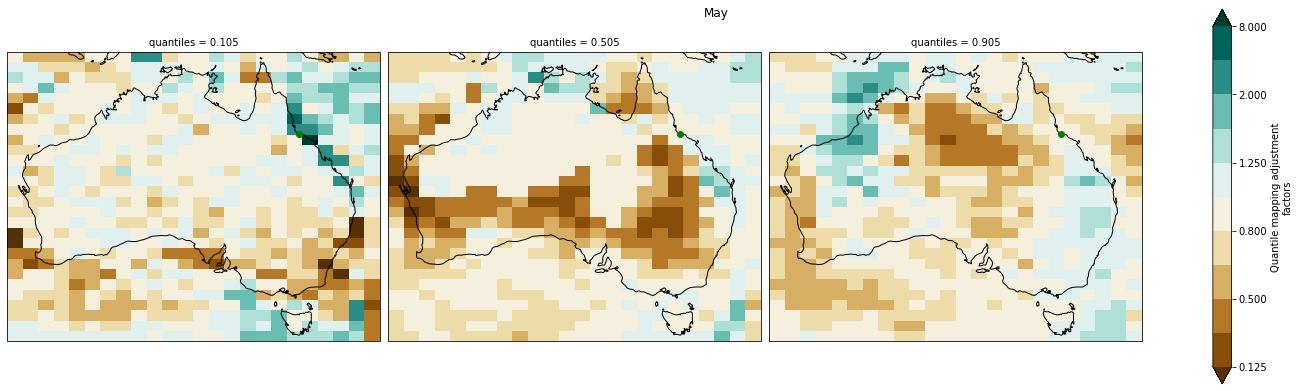

In [22]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'],
        example_month,
        'diverging',
        levels=plot_config['af_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

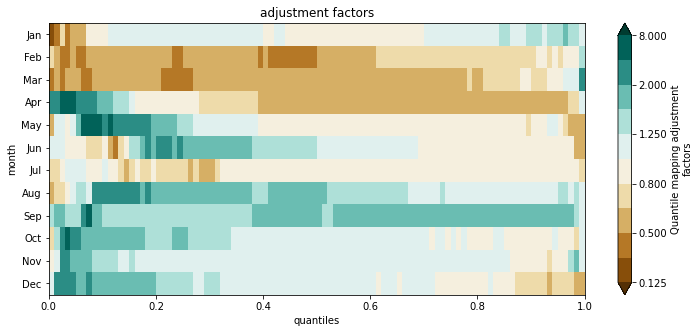

In [23]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

quantile_month_plot(
    ds_adjust['af'],
    ax1,
    'diverging',
    levels=plot_config['af_levels'],
    title='adjustment factors'
)

plt.show()

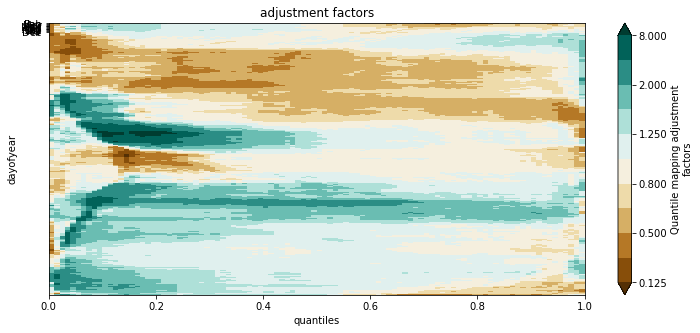

In [76]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

quantile_month_plot(
    ds_adjust_31day['af'],
    ax1,
    'diverging',
    levels=plot_config['af_levels'],
    title='adjustment factors',
    group_dim='dayofyear',
)

plt.show()

In [24]:
if len(ds_adjust['lat']) != len(target_q['lat']):
    regridder = xe.Regridder(ds_adjust['af'], target_q, "bilinear")
    af_regridded = regridder(ds_adjust['af'])

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


## QQ-scaled data

In [17]:
model_sel = {'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}

In [18]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True)
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True)
target_clim = ds_target[target_var].mean('time', keep_attrs=True)
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True)

In [19]:
if len(hist_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(hist_clim, qq_clim, "bilinear")
    hist_clim = regridder(hist_clim)

if len(ref_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(ref_clim, qq_clim, "bilinear")
    ref_clim = regridder(ref_clim)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key i

In [20]:
hist_ref_mean_diff = ref_clim - hist_clim
hist_ref_mean_diff = hist_ref_mean_diff.compute()

[########################################] | 100% Completed | 31.0s


In [21]:
qq_mean_change = qq_clim - target_clim
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed |  5min 54.4s


In [22]:
difference = qq_mean_change - hist_ref_mean_diff

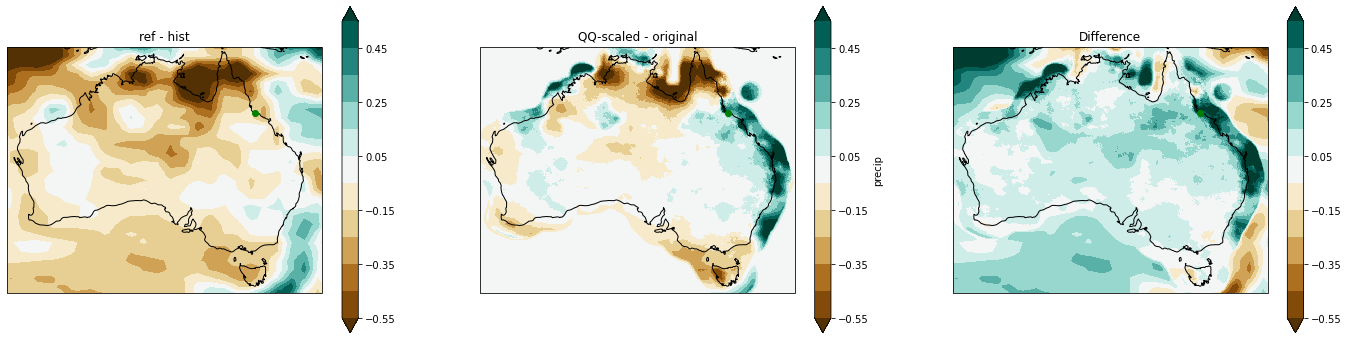

In [23]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax2.set_title('QQ-scaled - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  0.5s


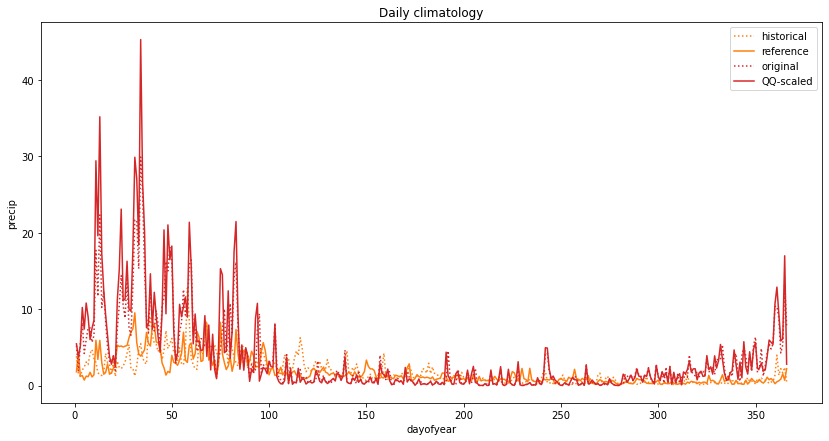

In [24]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[hist_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historical", color='tab:orange', linestyle=':')
ds_ref[ref_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="reference", color='tab:orange')
ds_target[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="original", color='tab:red', linestyle=':')
ds_qq[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed |  0.1s


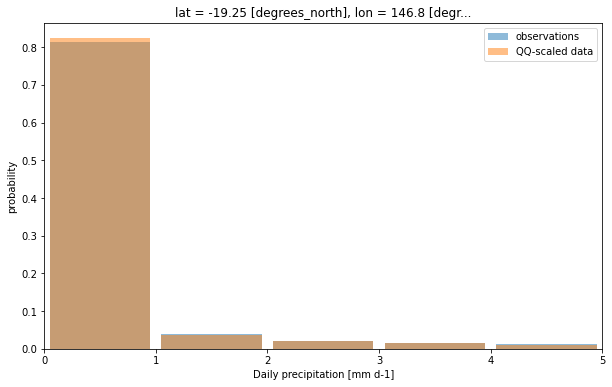

In [25]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
    
ds_target[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
ds_qq[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(0, 5)
plt.legend()
plt.show()

[########################################] | 100% Completed |  0.1s


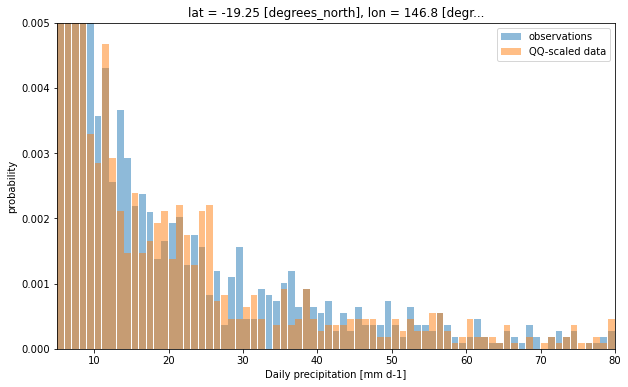

In [26]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
    
ds_target[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
ds_qq[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.ylim(0, 0.005)
plt.xlim(5, 80)
plt.legend()
plt.show()